<a href="https://colab.research.google.com/github/harsh-bat/tensorFlow2Learn/blob/master/Wor2Vec_Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-09-14 11:53:49--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.76.22
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.76.22|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [2]:
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True, )

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
word2vec.word_vec("test").shape

(300,)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding 
from tensorflow.keras.models import Model

In [23]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2020-09-14 11:59:38--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.81.48, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.005s  

2020-09-14 11:59:38 (106 MB/s) - ‘spam.csv’ saved [503663/503663]



In [24]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.columns = ['labels', 'data']
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [25]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [26]:
V = len(tokenizer.word_index) + 1 

In [27]:
data_train = pad_sequences(sequences_train)

In [28]:
T = data_train.shape[1]

In [29]:
data_test = pad_sequences(sequences_test, maxlen=T)

In [30]:
embedding_matrix = np.zeros((V , 300))
for word,ind in tokenizer.word_index.items():
  try:
    embedding_matrix[ind,:] = word2vec.word_vec(word).reshape(300)
  except:
    pass

In [41]:
M = 15



i = Input(shape=(T,))
x = Embedding(V, 300, weights=[embedding_matrix], trainable=False)(i)

# Now we have N x T x D

x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [42]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [43]:
r = model.fit(
   data_train,
  Ytrain,
  epochs=20,
  validation_data=(data_test, Ytest)
)

Epoch 1/20
117/117 [==============================] - 2s 16ms/step - loss: 0.3524 - accuracy: 0.8795 - val_loss: 0.1865 - val_accuracy: 0.9489
Epoch 2/20
117/117 [==============================] - 1s 12ms/step - loss: 0.1419 - accuracy: 0.9646 - val_loss: 0.1304 - val_accuracy: 0.9641
Epoch 3/20
117/117 [==============================] - 1s 12ms/step - loss: 0.1034 - accuracy: 0.9778 - val_loss: 0.1057 - val_accuracy: 0.9734
Epoch 4/20
117/117 [==============================] - 1s 12ms/step - loss: 0.0820 - accuracy: 0.9821 - val_loss: 0.0855 - val_accuracy: 0.9799
Epoch 5/20
117/117 [==============================] - 2s 13ms/step - loss: 0.0714 - accuracy: 0.9845 - val_loss: 0.0790 - val_accuracy: 0.9810
Epoch 6/20
117/117 [==============================] - 2s 13ms/step - loss: 0.0602 - accuracy: 0.9874 - val_loss: 0.0725 - val_accuracy: 0.9815
Epoch 7/20
117/117 [==============================] - 1s 13ms/step - loss: 0.0530 - accuracy: 0.9885 - val_loss: 0.0718 - val_accuracy: 0.9782

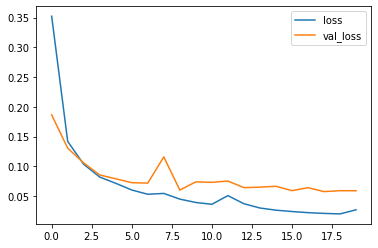

In [44]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

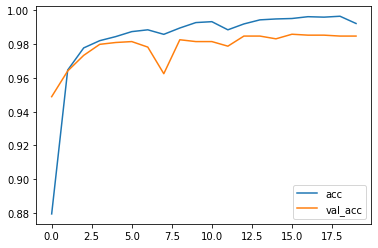

In [45]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [46]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 189, 300)          2185800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 189, 15)           18960     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 2,204,776
Trainable params: 18,976
Non-trainable params: 2,185,800
_________________________________________________________________


In [47]:
V

7286